<a href="https://colab.research.google.com/github/Chiebukar/Identify-gender-with-AFRIFASHION1600/blob/main/identify_gender_AFRIFASHION1600.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
import plotly.graph_objects as go
from  sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten,Dropout
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.preprocessing.image import load_img, img_to_array

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# read csv file 
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/AFRIFASHION1600.csv')

## Exploratory Data Analysis

In [4]:
# preview data 
data.head()

,image_id,clothing,gender
0,African_Blouse_1.png,African Blouse,Female
1,African_Blouse_10.png,African Blouse,Female
2,African_Blouse_100.png,African Blouse,Female
3,African_Blouse_101.png,African Blouse,Female
4,African_Blouse_102.png,African Blouse,Female


In [5]:
# show length of dataframe
len(data)

1600

In [6]:
# show shape of dataframe
data.shape

(1600, 3)

In [7]:
# show dataframe info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1600 non-null   object
 1   clothing  1600 non-null   object
 2   gender    1600 non-null   object
dtypes: object(3)
memory usage: 37.6+ KB


In [8]:
# data description
data.describe()

,image_id,clothing,gender
count,1600,1600,1600
unique,1600,8,2
top,Skirt and Blouse_175.png,Buba and Trouser,Female
freq,1,200,1000


In [9]:
# check for null values
data.isnull().sum()

image_id    0
clothing    0
gender      0
dtype: int64

In [10]:
# show data types of columns
data.dtypes

image_id    object
clothing    object
gender      object
dtype: object

In [11]:
# show columns in dataframe
data.columns

Index(['image_id', 'clothing', 'gender'], dtype='object')

In [12]:
# show unique values in 'clothing' column
data['clothing'].unique()

array(['African Blouse', 'African Shirts', 'Agbada', 'Buba and Trouser',
       'Gele', 'Gown', 'Skirt and Blouse', 'Wrapper and Blouse'],
      dtype=object)

In [13]:
# show unique values in 'gender' column
data['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [14]:
# show unique 'clothing' for females in datafraame
data[data['gender']== 'Female']['clothing'].unique()

array(['African Blouse', 'Gele', 'Gown', 'Skirt and Blouse',
       'Wrapper and Blouse'], dtype=object)

In [15]:
# show unique 'clothing' for males in datafraame
data[data['gender']== 'Male']['clothing'].unique()

array(['African Shirts', 'Agbada', 'Buba and Trouser'], dtype=object)

In [16]:
# create new dataframe with relevant columns
df = data[['image_id', 'gender']]

In [17]:
# get count of for each gender 
gender_count = pd.DataFrame(df['gender'].value_counts()).rename(columns= {'gender': 'Num_Values'})
gender_count

,Num_Values
Female,1000
Male,600


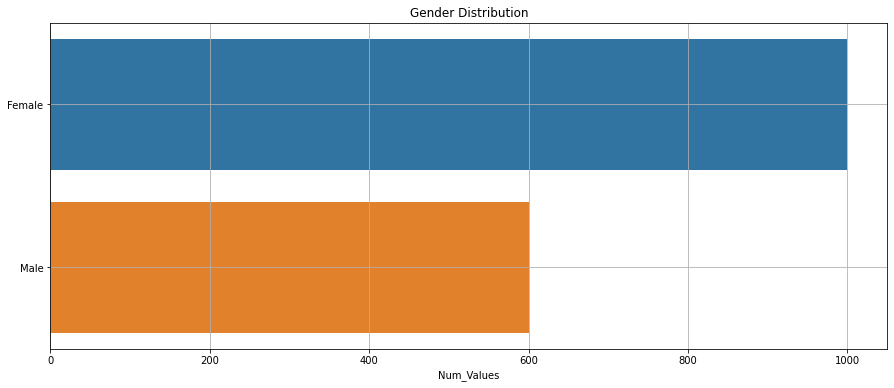

In [18]:
#display barplot of gender count
plt.figure(figsize = (15, 6))
sns.barplot(x= gender_count['Num_Values'], y= gender_count.index.to_list())
plt.title('Gender Distribution')
plt.grid(True)
plt.show()

In [19]:
# display pieplot of label distribution
pie_plot = go.Pie(labels= gender_count.index.to_list(), values= gender_count.values.flatten(),
                 hole= 0.2, text= gender_count.index.to_list(), textposition='auto')
fig = go.Figure([pie_plot])
fig.update_layout(title_text='Pie Plot of Gender Distribution')
fig.show()

In [20]:
# define relevant variables
gender_dict = {0:'Females', 1: 'Male'}
CLASSES = list(gender_dict.values())
NUM_CLASSES = len(CLASSES)
CLASSES, NUM_CLASSES
BATCH_SIZE = 128

In [21]:
# preview dataframe
df.head()

,image_id,gender
0,African_Blouse_1.png,Female
1,African_Blouse_10.png,Female
2,African_Blouse_100.png,Female
3,African_Blouse_101.png,Female
4,African_Blouse_102.png,Female


In [22]:
# define path to image data
path = '/content/drive/MyDrive/Colab Notebooks/dataset/AFRIFASHION1600/'

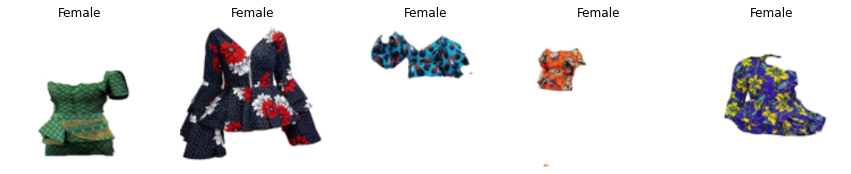

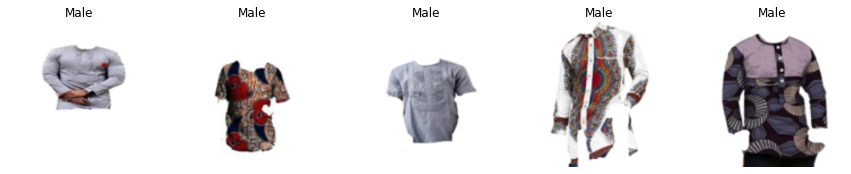

In [23]:
# display image samples

for i, gender in enumerate(df['gender'].unique()):
    values = df[df['gender']== gender]['image_id'].values
    fig = plt.figure(figsize = (15,6))
    for j, filename in enumerate(values[:5]):
        image_path = os.path.join(path, filename)
        img = cv2.imread(image_path)
        img = cv2.resize(img, (180, 180))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        fig.add_subplot(1, 5, j+1)
        plt.imshow(img)
        plt.subplots_adjust(hspace=0.5)
        plt.axis(False)
        plt.title(gender) 


## Data Augmentation

In [24]:
# split data into train, validation and test splits
train_data, test_data = train_test_split(df, test_size= 0.2, random_state=0, 
                                         shuffle=True, stratify= df['gender'])

val_data, test_data = train_test_split(test_data, test_size= 0.5, random_state=0, 
                                         shuffle=True, stratify= test_data['gender'])

In [25]:
# show shape of splits
train_data.shape, val_data.shape, test_data.shape

((1280, 2), (160, 2), (160, 2))

In [26]:
# define image generators
train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, vertical_flip=True, rescale=1/.255)


test_datagen = ImageDataGenerator(rescale=1/.255)

In [27]:
# read imagedata and apply data augmentation
train_gen = train_datagen.flow_from_dataframe(dataframe= train_data, directory= path, x_col='image_id',
                                             y_col= 'gender', target_size= (180,180),
                                              color_mode= 'rgb', class_mode= 'binary',
                                              batch_size= BATCH_SIZE, shuffle=True, seed=0)

val_gen = test_datagen.flow_from_dataframe(dataframe= val_data, directory= path, x_col='image_id',
                                             y_col= 'gender', target_size= (180,180),
                                              color_mode= 'rgb', class_mode= 'binary',
                                              batch_size= BATCH_SIZE, shuffle=True, seed=0)

test_gen = test_datagen.flow_from_dataframe(dataframe= test_data, directory= path, x_col='image_id',
                                             y_col= 'gender', target_size= (180,180),
                                              color_mode= 'rgb', class_mode= 'binary',
                                              batch_size= BATCH_SIZE, shuffle=True, seed=0)

Found 1280 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.


In [28]:
# show shape of data batches
for data_batch, labels_batch in train_gen:
    print('data batch shape: {} \n labels batch shape: {}'.format(data_batch.shape, labels_batch.shape))
    break

data batch shape: (128, 180, 180, 3) 
 labels batch shape: (128,)


## Model Building

In [29]:
# initialize pretrained model
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [30]:
# show trainable layers before freezing
print('This is the number of trainable weights '
'before freezing the conv base:', len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [31]:
# freeze few layers pf pretrained model
for layer in conv_base.layers[:-3]:
    layer.trainable= False

# show trainable layers after freezing
print('This is the number of trainable weights '
'after freezing part of the conv base:', len(conv_base.trainable_weights))    

This is the number of trainable weights after freezing part of the conv base: 4


In [32]:
# create model
model = Sequential([conv_base,
                   Flatten(),
                   Dropout(0.2),
                   Dense(1, activation='sigmoid')])

In [33]:
# compile model
model.compile(optimizer= Adam(0.0001), loss= 'binary_crossentropy', metrics=['accuracy'])

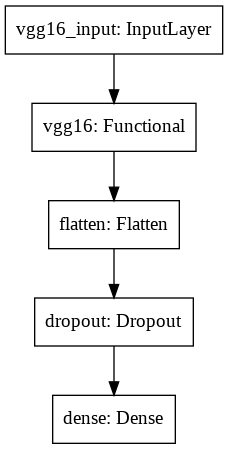

In [34]:
# display model achitecture
plot_model(model, 'model achitecture.png')

In [35]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_loss', patience = 10, verbose=1, mode='min', restore_best_weights= True)

checkpoint = ModelCheckpoint('gender_model.weights.hdf5', monitor='val_loss', verbose=1,save_best_only=True, mode= 'min')

In [36]:
# define training steps
TRAIN_STEPS = len(train_data)//BATCH_SIZE
VAL_STEPS = len(val_data)//BATCH_SIZE

In [37]:
# train model 
history = model.fit(train_gen, steps_per_epoch= TRAIN_STEPS, validation_data= val_gen,
                   validation_steps= VAL_STEPS, epochs= 50, callbacks= [reduceLR, early_stopping,
                                                                       checkpoint])

Epoch 1/50
10/10 [==============================] - 259s 20s/step - loss: 14.5164 - accuracy: 0.6132 - val_loss: 7.0949 - val_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 7.09495, saving model to gender_model.weights.hdf5
Epoch 2/50
10/10 [==============================] - 11s 1s/step - loss: 4.4566 - accuracy: 0.7322 - val_loss: 2.0390 - val_accuracy: 0.7812

Epoch 00002: val_loss improved from 7.09495 to 2.03899, saving model to gender_model.weights.hdf5
Epoch 3/50
10/10 [==============================] - 11s 1s/step - loss: 2.7026 - accuracy: 0.7047 - val_loss: 1.2408 - val_accuracy: 0.7812

Epoch 00003: val_loss improved from 2.03899 to 1.24079, saving model to gender_model.weights.hdf5
Epoch 4/50
10/10 [==============================] - 11s 1s/step - loss: 1.3184 - accuracy: 0.6928 - val_loss: 0.7896 - val_accuracy: 0.7422

Epoch 00004: val_loss improved from 1.24079 to 0.78959, saving model to gender_model.weights.hdf5
Epoch 5/50
10/10 [===========================

In [38]:
# read training history into dataframe
history_df = pd.DataFrame(history.history)

In [39]:
# preview train history dataframe
history_df.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,11.155356,0.659375,7.094948,0.750000,0.0001
1,4.195279,0.720312,2.038994,0.781250,0.0001
2,2.171923,0.708594,1.240792,0.781250,0.0001
3,1.246768,0.695312,0.789587,0.742188,0.0001
4,0.846632,0.683594,0.649642,0.703125,0.0001


In [40]:
# show train history columns
history_df.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'], dtype='object')

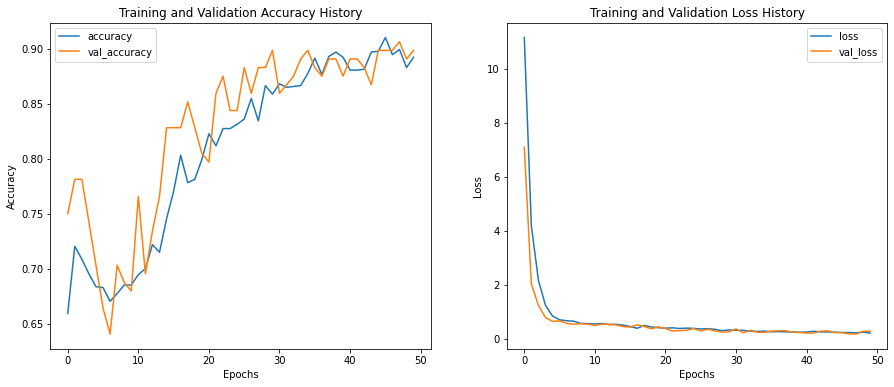

In [41]:
# display training and validation history

# display history of accurracy
plt.figure(figsize= (15,6))
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'], label= 'accuracy' )
plt.plot(history_df['val_accuracy'], label= 'val_accuracy')
# history_df[['acc', 'val_acc']]
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()

# display history of accurracy
plt.subplot(1,2,2)
plt.plot(history_df['loss'], label= 'loss')
plt.plot(history_df['val_loss'], label= 'val_loss')
# history_df[['loss', 'val_loss']].plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()

plt.show()

In [42]:
# load best weights
model.load_weights('gender_model.weights.hdf5')

In [43]:
# save model
model.save('/content/drive/MyDrive/Colab Notebooks/dataset/afri_gender_model.h5')

In [44]:
# save model weights
model.save_weights('/content/drive/MyDrive/Colab Notebooks/dataset/afri_gender_weights.hdf5')

## Model Testing and Evaluation

In [45]:
# evaluate model on validation set
val_eval = model.evaluate(val_gen)
print('Model performance on the validation set: \n Loss: {} \n Accuracy: {}%'.format(val_eval[0], int(val_eval[1]*100) ))

2/2 [==============================] - 5s 4s/step - loss: 0.2502 - accuracy: 0.9000
Model performance on the validation set: 
 Loss: 0.2501761317253113 
 Accuracy: 89%


In [ ]:
# get test data prediction
y_predicted = (model.predict_generator(test_gen) > 0.5).astype("int32")

In [70]:
# get test data true labels
y_truth = []
for i in range(VAL_STEPS+1):
  y_truth.extend(test_gen[i][1])

y_truth = np.array(y_truth).astype("int32")

In [63]:
# get labels
labels = [label for label in val_gen.class_indices.keys()]
labels

['Female', 'Male']

In [64]:
# evaluate model on validation set
test_eval = model.evaluate(test_gen)
print('Model performance on the test set: \n Loss: {} \n Accuracy: {}%'.format(test_eval[0], int(test_eval[1]*100) ))

2/2 [==============================] - 1s 99ms/step - loss: 0.4701 - accuracy: 0.8750
Model performance on the test set: 
 Loss: 0.4701290726661682 
 Accuracy: 87%


In [72]:
# evaluate model
accuracy_score(y_truth, y_predicted)

0.875

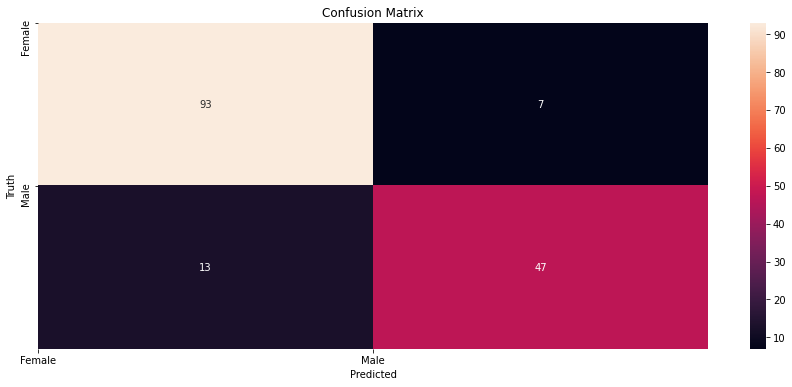

In [73]:
# display confusion matrix
plt.figure(figsize=(15,6))
cm = confusion_matrix(y_truth, y_predicted)
sns.heatmap(cm, annot= True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.show()

In [74]:
# display classification report
print('Classification Report \n', classification_report(y_truth, y_predicted))

Classification Report 
               precision    recall  f1-score   support

           0       0.88      0.93      0.90       100
           1       0.87      0.78      0.82        60

    accuracy                           0.88       160
   macro avg       0.87      0.86      0.86       160
weighted avg       0.87      0.88      0.87       160



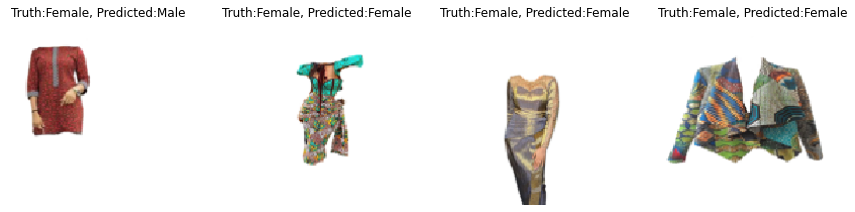

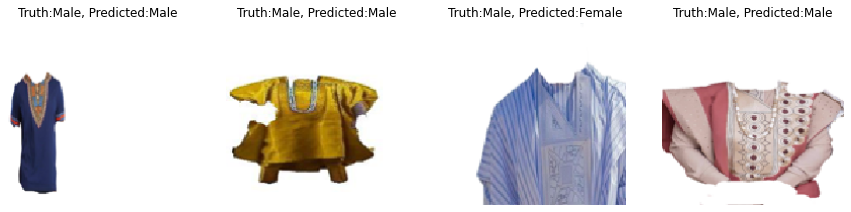

In [75]:
# plot sample images with true and predicted labels
for i, label in enumerate(labels):
  class_series = test_data[test_data['gender']== label]['image_id']
  values = class_series.values
  fig = plt.figure(figsize = (15,6))
  for j, filename in enumerate(values[:4]):
    image_path = os.path.join(path, filename)
    img = load_img(image_path, target_size = (180,180))
    test_img = img_to_array(img)
    test_img = np.expand_dims(test_img, axis = 0)
    predicted  = (model.predict(test_img)).round()
    predicted_label = labels[int(predicted)]
    fig.add_subplot(1,4, j+1)
    plt.imshow(img)
    plt.subplots_adjust(hspace=0.5)
    plt.axis(False)
    plt.title('Truth:{0}, Predicted:{1}'.format(label, predicted_label))
plt.show()